In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [30]:
def bn_ReLU_conv2D(x, filters, kernel_size):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding = "same")(x)
    
    return x


def transition_block(x):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(x.shape[-1] // 2, 1, padding = "same")(x)
    x = tf.keras.layers.AveragePooling2D((2, 2), strides = 2)(x)

    return x


def dense_block(x, num_conv, growth_rate):
    for i in range(num_conv):
        residual = x
        x = bn_ReLU_conv2D(x, 4 * growth_rate, 1)
        x = bn_ReLU_conv2D(x, growth_rate, 3)
        x = tf.keras.layers.Concatenate(axis = -1)([x, residual])

    return x

In [34]:
IMAGE_SIZE = [224, 224] # Cropped ImageNet test size.

def create_NN(model_name, growth_rate = 32):
    model_input = tf.keras.layers.Input((*IMAGE_SIZE, 1))

    ## Entry Flow
    x = tf.keras.layers.Conv2D(2 * growth_rate, 7, strides = 2, padding = "same")(model_input)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides = 2, padding = "same")(x)


    ## Middle Flow
    for i, num_conv in enumerate([6, 12, 24, 16]):
        x = dense_block(x, num_conv, growth_rate)
        if i is not 3: 
            x = transition_block(x)

    ## Exit Flow
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1000)(x)
    model_output = tf.keras.layers.Softmax()(x)

    model = tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)
    
    return model

In [35]:
tmp = create_NN("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_381 (Conv2D)             (None, 112, 112, 64) 3200        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_381[0][0]                 
__________________________________________________________________________________________________
batch_normalization_371 (BatchN (None, 56, 56, 64)   256         max_pooling2d_7[0][0]            
________________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.703864 to fit



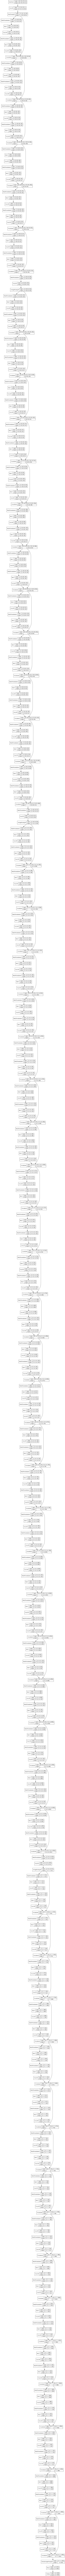

In [36]:
tf.keras.utils.plot_model(tmp, show_shapes = True, show_layer_names = False)